The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect's services
Interconnect mainly provides two types of services:

Landline communication. The telephone can be connected to several lines simultaneously.
Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
Some other services the company provides include:

Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
A dedicated technical support line (TechSupport)
Cloud file storage and data backup (OnlineBackup)
TV streaming (StreamingTV) and a movie directory (StreamingMovies)
The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

Data Description
The data consists of files obtained from different sources:

contract.csv — contract information
personal.csv — the client's personal data
internet.csv — information about Internet services
phone.csv — information about telephone services
In each file, the column customerID contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

Dataset
You can download the dataset by following this link.

The data is also available for usage on the platform in the /datasets/final_provider/ folder.

Clarification: Summary
Target feature: the 'EndDate' column equals 'No'.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Assessment criteria:

AUC-ROC < 0.75 — 0 SP
0.75 ≤ AUC-ROC < 0.81 — 4 SP
0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
0.85 ≤ AUC-ROC < 0.87 — 5 SP
0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
AUC-ROC ≥ 0.88 — 6 SP

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

Import Data

In [4]:
contract_df = pd.read_csv(r"E:\final_provider\contract.csv")

In [5]:
internet_df = pd.read_csv(r"E:\final_provider\internet.csv")

In [6]:
personal_df = pd.read_csv(r"E:\final_provider\personal.csv")

In [7]:
phone_df = pd.read_csv(r"E:\final_provider\phone.csv")

Lets take a look at our data!

In [9]:
print("Contract DataFrame:")
print(contract_df.head())
print("\nPersonal DataFrame:")
print(personal_df.head())
print("\nInternet DataFrame:")
print(internet_df.head())
print("\nPhone DataFrame:")
print(phone_df.head())

Contract DataFrame:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  

Personal DataFrame:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes

We can see above that we have a lot of information available from our inital datasets. Some of it we may not need and may cause some adverse affects when we go to train our model. We see that we have a unique customer id in all of the datasets so we will be able to merge them on that! There is no missing data in the heads at least but we will keep investigating that.

In [11]:
# Display shapes of the DataFrames
print("Shapes of the DataFrames:")
print(f"Contract: {contract_df.shape}, Personal: {personal_df.shape}, Internet: {internet_df.shape}, Phone: {phone_df.shape}")

# Display basic statistics
print("\nContract DataFrame Statistics:")
print(contract_df.describe(include='all'))

print("\nPersonal DataFrame Statistics:")
print(personal_df.describe(include='all'))

print("\nInternet DataFrame Statistics:")
print(internet_df.describe(include='all'))

print("\nPhone DataFrame Statistics:")
print(phone_df.describe(include='all'))

Shapes of the DataFrames:
Contract: (7043, 8), Personal: (7043, 5), Internet: (5517, 8), Phone: (6361, 2)

Contract DataFrame Statistics:
        customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77       5               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5174            3875             4171   
mean           NaN         NaN     NaN             NaN              NaN   
std            NaN         NaN     NaN             NaN              NaN   
min            NaN         NaN     NaN             NaN              NaN   
25%            NaN         NaN     NaN             NaN              NaN   
50%            NaN         NaN     NaN             NaN              NaN   
75%            NaN         NaN     NaN             NaN              NaN   
max            NaN         NaN     Na

In [12]:
# Check for missing values
print("Missing Values in Contract DataFrame:")
print(contract_df.isnull().sum())

print("\nMissing Values in Personal DataFrame:")
print(personal_df.isnull().sum())

print("\nMissing Values in Internet DataFrame:")
print(internet_df.isnull().sum())

print("\nMissing Values in Phone DataFrame:")
print(phone_df.isnull().sum())

Missing Values in Contract DataFrame:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Missing Values in Personal DataFrame:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Missing Values in Internet DataFrame:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Missing Values in Phone DataFrame:
customerID       0
MultipleLines    0
dtype: int64


In [13]:
print("Contract DataFrame:")
print(contract_df.info())
print("\nPersonal DataFrame:")
print(personal_df.info())
print("\nInternet DataFrame:")
print(internet_df.info())
print("\nPhone DataFrame:")
print(phone_df.info())

Contract DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Personal DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3 

We can see above that we are looking pretty good with no missing values. We can also see the data we have in some of the columns and the amount of unique values they have or if they are just a yes/no answer. I do see in a few of these dataframes where we need to make some Dtype changes like to date time and from object to float or int64. We can also go ahead and combine the dataframes into one for when we do our model training and testing later on.

In [15]:
# Merge DataFrames
combined_df = contract_df.merge(personal_df, on='customerID', how='left') \
                           .merge(internet_df, on='customerID', how='left') \
                           .merge(phone_df, on='customerID', how='left')

# Display the shape of the combined DataFrame
print(f"Combined DataFrame Shape: {combined_df.shape}")

# Display the first few rows of the combined DataFrame
print(combined_df.head())

Combined DataFrame Shape: (7043, 20)
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female          

In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [17]:
# Check for duplicate rows
duplicates = combined_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [18]:
# Check for missing values
print("Missing Values in Combined DataFrame:")
print(combined_df.isnull().sum())

Missing Values in Combined DataFrame:
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


After combinging our datasets we can see now that we have some missing data. This could just be people who have telephone service and no internet service. I say this because in the original datasets for internet and for the phone we had less customer ids then the contract dataset. The amount of the missing values is the same as the differnce in customer id numbers. We will have to decide what to do with this data. It may be a matter of filling the 1526 missing with No and doing the same with 682 missing in the multiple lines column. 

In [20]:
combined_df['TotalCharges'] = pd.to_numeric(combined_df['TotalCharges'], errors='coerce')

In [21]:
# Convert BeginDate to datetime
combined_df['BeginDate'] = pd.to_datetime(combined_df['BeginDate'],errors='coerce')

# Convert EndDate to datetime
combined_df['EndDate'] = pd.to_datetime(combined_df['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [22]:
combined_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Above you can see i converted the Total Charges column to an int64 from an object just in case we needed to do any maths later. I also converted the Begin Date and End date to the DateTime Dtype so then i could make a new feature column for tenure because that will be a helpful metric I would think.

In [24]:
combined_df.fillna({
    'InternetService': 'No',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'MultipleLines': 'No'
}, inplace=True)

In [25]:
print("Missing Values in Combined DataFrame:")
print(combined_df.isnull().sum())

Missing Values in Combined DataFrame:
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64


Now that we have the datasets combined, we have filled the missing values from the phone and internet with No values, and we converted our data to the correct data types. The remaining missing values that we have now are there becuse the 11 values in Total Charges are people who have just signed up when our data ends so even tho they signed contacts we dont have any total charges for them yet. Its probably safe to drop those 11 because it is so small. The 5174 now missing in the EndDate column are the amount of people who have not ended their contract yet. After converting to DateTime all of the No values that were there became NaT values. We can probably use that data to make us a column for whether or not the customer churned.

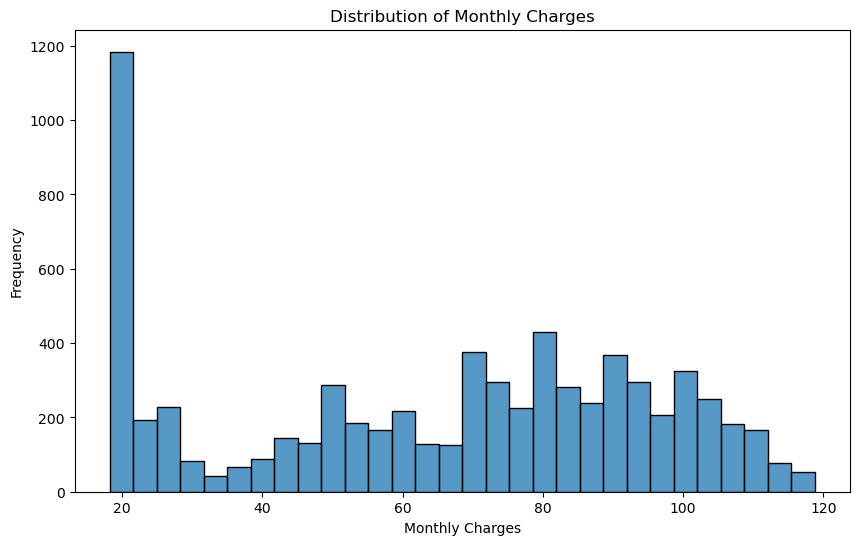

In [27]:
# Histogram for Monthly Charges
plt.figure(figsize=(10,6))
sns.histplot(combined_df['MonthlyCharges'], bins=30)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()


Text(0, 0.5, 'Count')

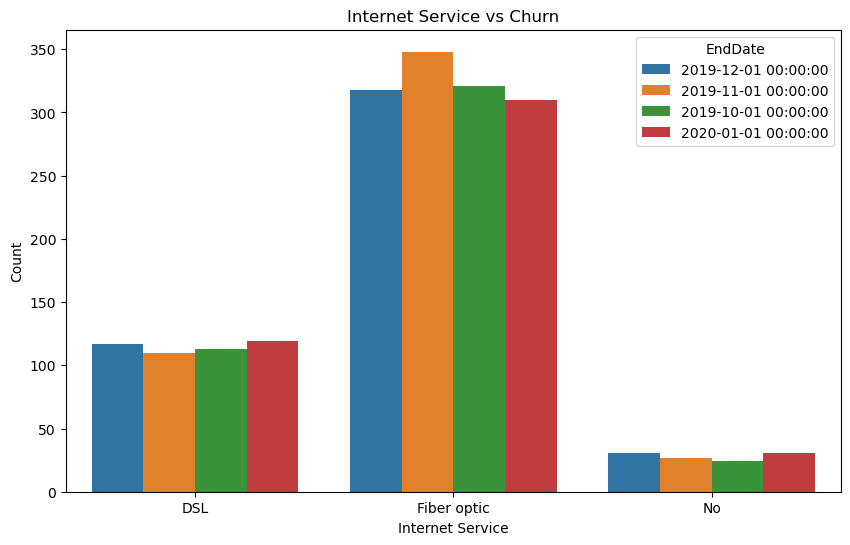

In [28]:
# Count plot for Internet Service
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x='InternetService', hue='EndDate')
plt.title('Internet Service vs Churn')
plt.xlabel('Internet Service')
plt.ylabel('Count')

In [29]:
plt.show()

In [30]:
combined_df['EndDate'].isna().sum() / len(combined_df['EndDate']) * 100

73.4630129206304

So we can see above that the most people that leave the internet is our fiber optic customers by a pretty hefty amount. We can also see in the line below the chart that in total about 27% of customers have left overall which is pretty significant. We also see that most people leave in the fall months. 

## Work Plan

I have already dont a lot of the preprocessing of the data and the initial EDA. Going forward my first steps will be to:
- Finish any preprocessing that still may need to be done, including converting column names to lowercase
- Do a bit more in depth EDA for example compare the features of churners vs non churners. Make some plots to spot any correlations with age or gender and churn rate. 
- Next I will start my feature engineering. As of right now it looks like I will create two new columns for Tenure and Churn(yes or no). I will also encode the categorical features so I can use them on various different models without issue. I will also determine which features have the most importance to use with the model we will be training.
- Next we will split the data into our training and test sets and choose our features and our target(Churn == No)
- After the data is split I will fit a few different models with the training data and evaluate its AUC-ROC and accuracy scores
- Once I have determined the initial scores of the models I will then use Gridsearch or Randomsearch to tune the hyperparameters for the best model
- With the best parameters found I will train again on the training set and then I will make predictions by using the Test set.
- Lastly I will analyze the score of the model to make sure it meets the criteria I am looking to acheive. If so I will write up a conclusion with my results, if not I will further tune the data or change the model to make it work.
  

## Questions

Do you think it will be best to just drop the 11 customers in the total charges column?

Should we take into account and look at the seasonality of when the customer started service vs when the customer stopped service or even if they havent stopped service? For example say people who started the contract in the summer tend not to churn.

Do you see any reason to scale the data?

For the features will it be a good idea to use everything except for Begin and End Date, and customer Id?

Will i need to encode the columns that already have Yes/No answers?


In [36]:
combined_df.columns = combined_df.columns.str.lower()

In [37]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   object        
 14  onlinebackup      7043 n

Above I converted my column names to lowercase for consistancy and ease of coding going forward.

In [39]:
combined_df['totalcharges'] = combined_df['totalcharges'].fillna(combined_df['monthlycharges'])

In [40]:
combined_df['totalcharges'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: totalcharges
Non-Null Count  Dtype  
--------------  -----  
7043 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB


In [41]:
print(combined_df['monthlycharges'][5218])
combined_df['totalcharges'][5218]

19.7


19.7

I chose to fill the 11 missing total charges with the data from the monthly charges of the same row. I did this because looking at the raw data in excel you see that the 11 total charges that were missing were from the 11 people that just signed up on the last day we have data for and they all have 2 year contracts. This seemed like the best approach to me.

In [43]:
# Making a Churn column (1 for churn, 0 for no churn)
combined_df['churn'] = combined_df['enddate'].notna().astype(int)

In [44]:
combined_df['churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int32

In [45]:
combined_df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

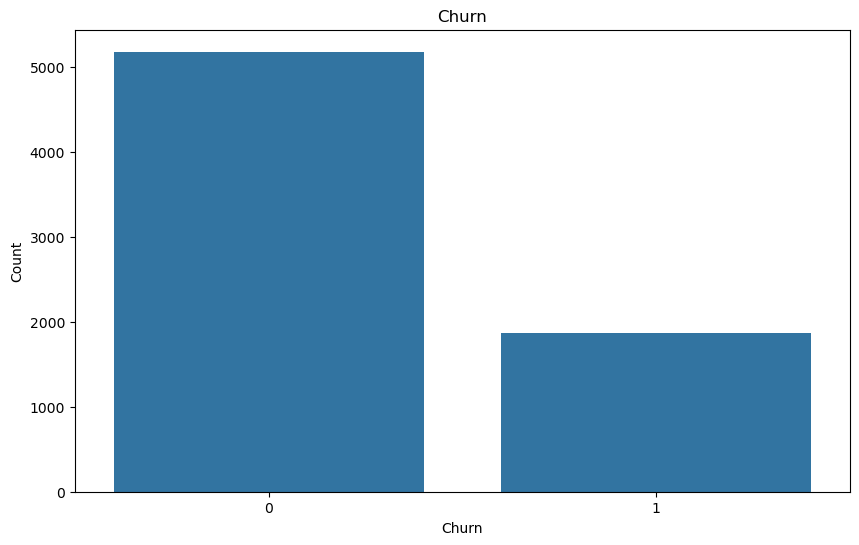

In [46]:
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x='churn')
plt.title('Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

We can see here that we have a bit of a class imbalance here. We will have to deal with that before training our model

In [48]:
last_date = pd.to_datetime('2020-02-01')
combined_df['tenure'] = (last_date - combined_df['begindate']).dt.days

#(combined_df['enddate']) - (combined_df['begindate'])

In [49]:
combined_df['tenure'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: tenure, dtype: int64

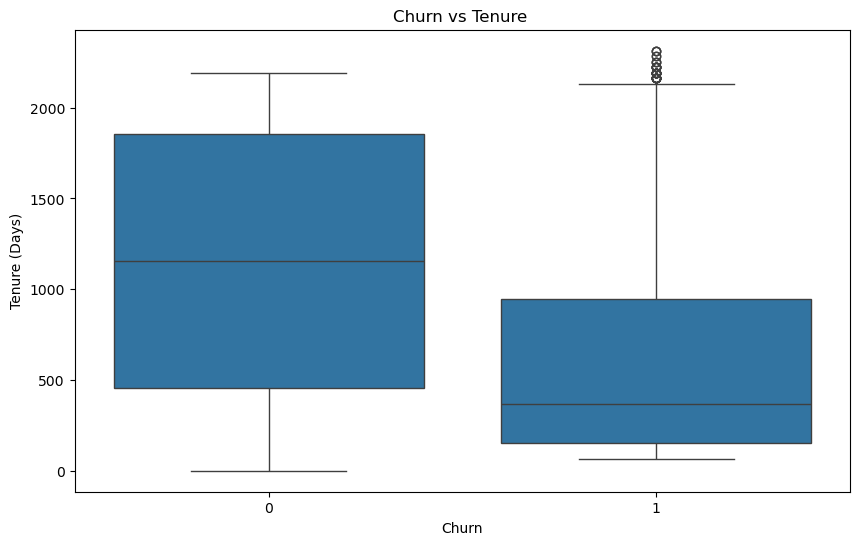

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='tenure', data=combined_df)
plt.title('Churn vs Tenure ')
plt.xlabel('Churn')
plt.ylabel('Tenure (Days)')
plt.show()

The above boxplot shows the distrubution of tenure for customers who churned (1) and those who did not (0). Customers who did churn have significantly lower median tenure then customers who did not churn. We also see that customers who churned have a more spread out distrubution of tenure with a longer tail to the right. We also see some outliers in the customers who churned particularly customers who had a high tenure above 2000 days. Overall we can see from this plot that tenure could be a large factor in churn. We can also see a large difference in distrubution of tenure between customers who churned and those who have not.

In [52]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   object        
 14  onlinebackup      7043 n

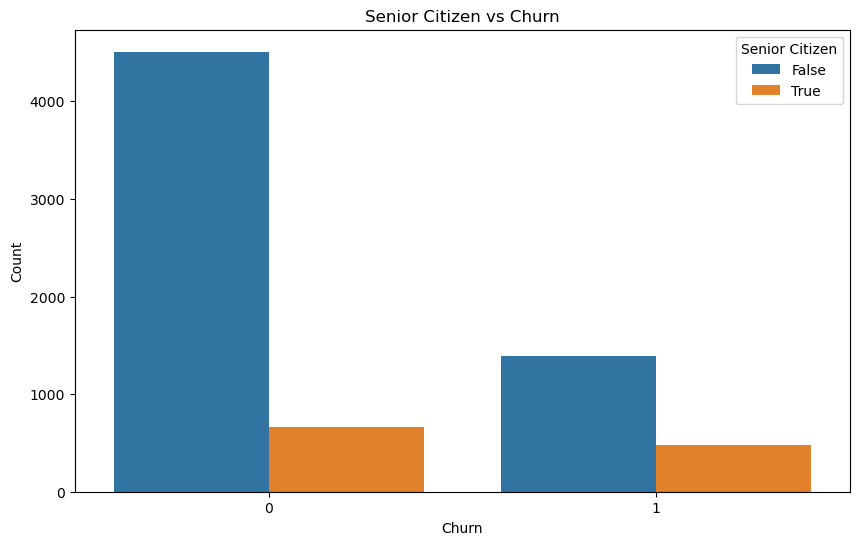

In [53]:
# Count plot for Internet Service
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x='churn', hue='seniorcitizen')
plt.title('Senior Citizen vs Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Senior Citizen', labels=['False', 'True'])
plt.show()

We can see above that we have more people who are not senior citizens who have churned then people who are senior citizens. We also see that overall we have more non senior citizen customers. We can also see that we have slightly more senior citizens who dont churn then those who do.

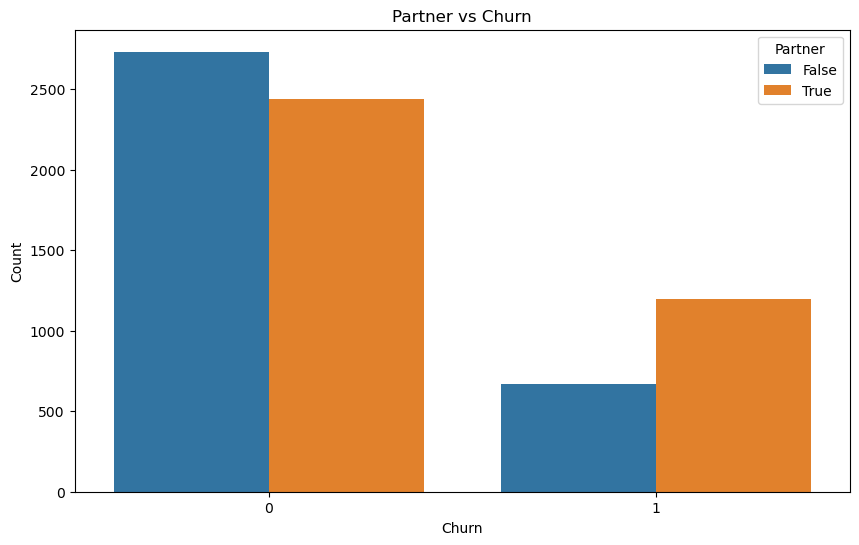

In [55]:
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x='churn', hue='partner')
plt.title('Partner vs Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Partner', labels=['False', 'True'])
plt.show()

We can see from this chart above that as far as people who churn are concerned there are more people with a partner that churn then people who are single. We can also see that we have significantly more of both groups that do not churn.

Above we have a visual of what our churn looks like. We can see that a little less then 50% of customers churn. Now we just need to see what keeps our customers around.

In [58]:
encoder = OrdinalEncoder()
columns_to_encode= ['paperlessbilling', 'gender', 'partner', 'dependents', 'internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies','multiplelines']
combined_df[columns_to_encode] = encoder.fit_transform(combined_df[columns_to_encode])
combined_df[columns_to_encode].head()

,paperlessbilling,gender,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Above I took all of my Yes/No binary columns and encoded them to 1's and 0's so we can use it to train our model.

In [60]:
combined_df = pd.get_dummies(combined_df, columns=['type', 'paymentmethod'], drop_first= True)

Above I have encoded my categorical features for use in training our model.

In [62]:
combined_df.drop(columns=['customerid','begindate','enddate'], inplace=True)


Dropped the columns I wont be using for the model training.

In [64]:
X = combined_df.drop('churn', axis=1)
y = combined_df['churn'] 

In [65]:
# First, split into training and validation/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)  # 60% train, 40% temp

# Now, split the temp set into validation and test sets (50% of temp = 20% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)  # 50% of temp for test


In [66]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4225
Validation set size: 1409
Test set size: 1409


In [67]:
smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [68]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=1234),
    'Random Forest': RandomForestClassifier(random_state=1234),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1234)
}

In [69]:
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)  # Use resampled training data
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC-ROC and accuracy
    auc_roc = roc_auc_score(y_val, y_val_proba)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"{name} - AUC-ROC: {auc_roc:.2f}, Accuracy: {accuracy:.2f}")


Logistic Regression - AUC-ROC: 0.80, Accuracy: 0.74
Random Forest - AUC-ROC: 0.84, Accuracy: 0.80
Gradient Boosting - AUC-ROC: 0.88, Accuracy: 0.83


We can see above that on our initial training of our models that the gradient boosting model has performed the best in both the AUC-ROC and the Accuracy metrics. The Random Forest model isn't doing to bad either at .84 and .80. For now I will try to tune the Gradient Boosting and the Random Forest models to see if I can make the scores a little bit higher still!

In [71]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [72]:
best_models = {}

In [73]:
# Hyperparameter tuning for each model
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grids[name], 
                               scoring='roc_auc', 
                               cv=5,  # 5-fold cross-validation
                               n_jobs=-1,  # Use all available cores
                               verbose=2)  # Show detailed progress updates
    
    # Fit the model
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    # Store the best model
    best_models[name] = best_model
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated AUC-ROC score for {name}: {best_score:.2f}")

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Logistic Regression: {'C': 0.1}
Best cross-validated AUC-ROC score for Logistic Regression: 0.86
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated AUC-ROC score for Random Forest: 0.96
Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated AUC-ROC score for Gradient Boosting: 0.98


In [74]:
for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC-ROC and accuracy
    auc_roc = roc_auc_score(y_val, y_val_proba)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"{name} - AUC-ROC: {auc_roc:.2f}, Accuracy: {accuracy:.2f}")

Logistic Regression - AUC-ROC: 0.80, Accuracy: 0.74
Random Forest - AUC-ROC: 0.85, Accuracy: 0.80
Gradient Boosting - AUC-ROC: 0.91, Accuracy: 0.86


After doing some hyperparameter tuning on our 3 models we have, we saw some significant improvements of all 3 of the models. The highest AUC-ROC score was .98 and our lowest became .86. Thes best model is still the Gradient Boosting model.
After the hyperparameter tuning was done I took the best models and fit them with the validation set data. We didnt see any change in the scores for the LR seem to have not changed. We see that after tuning the Random Forest AUC-ROC went up by one point but the accuracy stayed the same. We see the biggest score jump with the Gradient Boosting Model. This went from AUC-ROC of .88 up to .91 and an accuracy score of .83 to .86. The Gradient Boosting model seems to be performing really well. Lastly we will fit it with the test data and see what happens with that!

In [76]:
that_model = grid_search.best_estimator_

In [77]:
that_model

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, min_samples_leaf=2,
                           n_estimators=200, random_state=1234)

In [78]:
test_pred = that_model.predict(X_test)
test_proba = that_model.predict_proba(X_test)[:, 1]
    
# Calculate AUC-ROC and accuracy
test_auc_roc = roc_auc_score(y_test, test_proba)
test_accuracy = accuracy_score(y_test, test_pred)
    
print(f"Gradient Boosting Test Set Model - AUC-ROC: {test_auc_roc:.2f}, Accuracy: {test_accuracy:.2f}")

Gradient Boosting Test Set Model - AUC-ROC: 0.92, Accuracy: 0.89


## Conclusions

Above we have fitted the best performing model and made predictions. We got an amazing AUC-ROC score of .92 which is even a point higher then what we had with the validation set and our accuracy went up to .89. These scores indicate that our model can almost perfectly distinguish between classes and that 89% of predictions made by the model are correct. These numbers should be a good sound indicator of how our model is performing because we addressed the class imbalance issue earlier in the code with SMOTE and while hypertuning the parameters we made sure to cross validate to help ensure we were not overfitting. 
Overall using the Gradient Boosting Model with the hyperparameters shown will serve our purpose quite well.


## Solution Report

<ul>
<li>What steps of the plan were performed and what steps were skipped (explain why)</li>
<li>What difficulties did you encounter and how did you manage to solve them?</li>
<li>What were some of the key steps to solving the task?</li>
<li>What is your final model and what quality score does it have?</li>    
</ul>
<br>Starting at the top of my work plan, I finsihed up the preprocessing of the data after my initial EDA. This included converted all my column names to lowercase to make the coding a little easier and keep up consistancy. I also went ahead and filled in my missing data in the totalcharges column with the data from the monthlycharges column. I did this because the 11 customers without total charges had just signed up the month our data stopped.They all had 1 or 2 year contracts so I thought it was safe to assume they hadnt churned and their total charge would be whatever that months charges would have been. I then went and made two new columns that I thought would help and give us good data and easy useable binary churn column. The two columns I made are churn and tenure. I had a few hiccups doing the tenure. At first my data wasnt the right type to do the maths to get the number of days. After a little bit of searching I had found where I was going wrong and fixed that. After I finished doing that I went ahead and made a few more plots so I could get a better visual of our data. Doing that we were able to see the class imbalance that we had in our target. We also saw the handful of outliers that we had in tenure vs churn. This enabled me to know how to handle the data doing forward to train the models. The last bit of preproccessing that I did before i got into the models was i encoded all of my binary columns with OrdinalEncoder and then I did one hot encoding for my categorical features. I then dropped customerid, begindate, and enddate because they would not be needed for training the models.<br>
<br>    After all of the preproccessing and EDA was finished I went ahead set up my target and feature variables. I then split all of my data into a training set, a validation set, and a test set. From there I resampled the data using SMOTE as to take care of the class imbalance I had. Next I did the initial training of the 3 models I had chosen. I initially got some good scores but I wanted them to be better so I continued ahead and did some hyperparameter tuning of the three models and made predictions with the validation set. The scores once again improved greatly. I then took the best model with the best parameters and made predictions with the test set.<br> 
<br>    The results I got were the following: Gradient Boosting Test Set Model - AUC-ROC: 0.92, Accuracy: 0.89. These are some really great scores to get with this model. It shows we can distinguish between classes almost perfectly and that it makes predictions with 89% accuracy which is really good. Some of the challengers I ran into while doing this were trying to determine exactly what data I wanted to use and if there was any features I wanted to create and then how to create them. I also had a few hiccups while converting the begindate and enddate to datetime so I could make the tenure column. I had to go back and re read things on to_datetime and the format and syntax. Some of the key steps I found to solving this task were making sure my data was the correct type and understanding the distrubution and how all the data we have correlates to each other. Once thats figured out it goes real smooth.<br>
